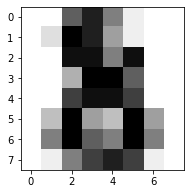

In [10]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

#Load the digits dataset
digits = datasets.load_digits()

#Display the first digit
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[-1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()


In [11]:
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
         [ 0.,  0., 13., ..., 15.,  5.,  0.],
         [ 0.,  3., 15., ..., 11.,  8.,  0.],
         ...,
         [ 0.,  4., 11., ..., 12.,  7.,  0.],
         [ 0.,  2., 14., ..., 12.,  0.,  0.],
         [ 0.,  0.,  6., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
         [ 0.,  0.,  0., ...,  9.,  0.,  0.],
         [ 0.,  0.,  3., ...,  6.,  0.,  0.],
         ...,
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  0., ..., 10.,  0.,  0.]],
 
        [[ 0

In [12]:
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# no CUDA, sorry :(

In [40]:
batch_size = 100

# train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
# test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

train_dataset, test_dataset, train_labels, test_labels = train_test_split(digits.images, digits.target, test_size=0.1)

train_loader = DataLoader(dataset=list(zip(train_dataset, train_labels)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=list(zip(test_dataset, test_labels)), batch_size=batch_size, shuffle=False)

In [35]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

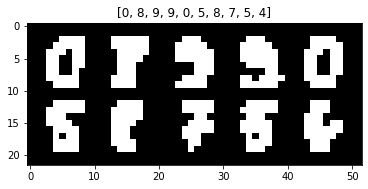

In [45]:
inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs[:10][:, None, :, :], nrow=5)
imshow(out, title=[x.item() for x in classes[:10]])

### GAN

In [5]:
class SmallGenerator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features * 2)
        self.fc3 = nn.Linear(self.fc2.out_features, g_output_dim)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x
    
class SmallDiscriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features // 2)
        self.fc3 = nn.Linear(self.fc2.out_features, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, 0.3)
        x = torch.sigmoid(self.fc3(x))
        return x

In [62]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 128)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features * 2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features * 2)
        self.fc4 = nn.Linear(self.fc3.out_features, self.fc3.out_features // 2)
        self.fc5 = nn.Linear(self.fc4.out_features, self.fc4.out_features // 2)
        self.fc6 = nn.Linear(self.fc5.out_features, g_output_dim)
        self.fc_layers = [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5, self.fc6]
        
    def forward(self, x):
        for layer in self.fc_layers[:-1]:
            x = F.leaky_relu(layer(x))

        x = torch.tanh(self.fc_layers[-1](x))
        return x
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features // 2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features // 2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
        self.fc_layers = [self.fc1, self.fc2, self.fc3, self.fc4]
        
    def forward(self, x):
        for layer in self.fc_layers[:-1]:
            x = F.dropout(F.leaky_relu(layer(x)), 0.3)

        x = torch.sigmoid(self.fc_layers[-1](x))
        return x

In [91]:
def D_train(D, x, labels, x_dim, z_dim):
    D.zero_grad()

    x_real, y_real = torch.cat((x.view(-1, x_dim).float(), labels.view(-1, 1).float()), dim=1), torch.ones(x.shape[0], 1)
    x_real, y_real = Variable(x_real), Variable(y_real)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    z = Variable(torch.cat((torch.randn(x.shape[0], z_dim).float(), labels.view(-1, 1).float()), dim=1))
    x_fake, y_fake = G(z), Variable(torch.zeros(z.shape[0], 1))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return D_loss.data.item()

In [92]:
def G_train(G, x, labels, z_dim):
    G.zero_grad()

    z = Variable(torch.cat((torch.randn(x.shape[0], z_dim).float(), labels.view(-1, 1).float()), dim=1))
    y = Variable(torch.ones(z.shape[0], 1))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [97]:
batch_size = 100

train_dataset, test_dataset, train_labels, test_labels = train_test_split(digits.images, digits.target, test_size=0.1)

train_loader = DataLoader(dataset=list(zip(train_dataset, train_labels)), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=list(zip(test_dataset, test_labels)), batch_size=batch_size, shuffle=False, drop_last=True)

In [102]:
z_dim = 32
x_dim = train_dataset.shape[1] * train_dataset.shape[2]

G = Generator(g_input_dim=z_dim+1, g_output_dim=x_dim+1)
D = Discriminator(x_dim+1)

In [103]:
criterion = nn.BCELoss() 

lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

16it [00:01,  8.02it/s]


[1/200]: loss_d: 0.768, loss_g: 0.713


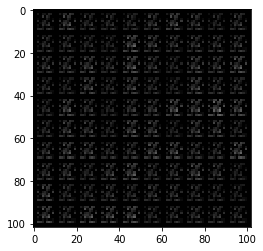

16it [00:01,  8.48it/s]


[2/200]: loss_d: 0.679, loss_g: 0.736


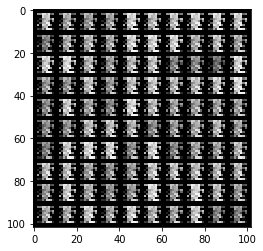

16it [00:02,  7.68it/s]


[3/200]: loss_d: 0.593, loss_g: 0.939


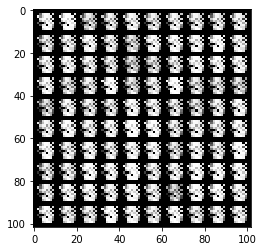

16it [00:01,  9.64it/s]


[4/200]: loss_d: 0.473, loss_g: 1.257


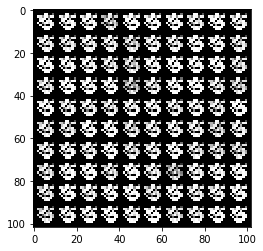

16it [00:02,  6.58it/s]


[5/200]: loss_d: 0.199, loss_g: 2.156


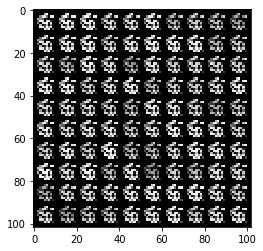

16it [00:02,  7.43it/s]


[6/200]: loss_d: 0.177, loss_g: 2.146


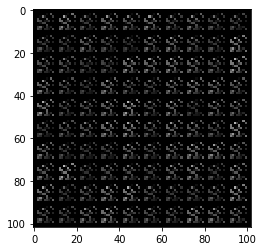

16it [00:01,  9.30it/s]


[7/200]: loss_d: 0.194, loss_g: 1.855


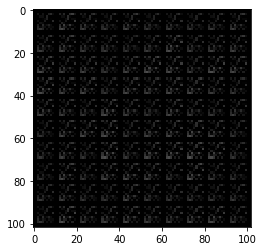

16it [00:01,  9.97it/s]


[8/200]: loss_d: 0.097, loss_g: 2.575


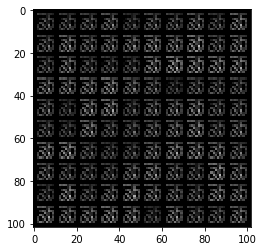

16it [00:01, 10.30it/s]


[9/200]: loss_d: 0.234, loss_g: 2.798


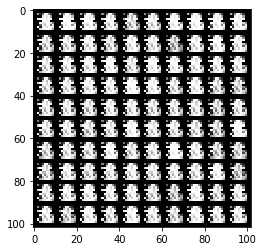

16it [00:02,  7.34it/s]


[10/200]: loss_d: 0.342, loss_g: 3.083


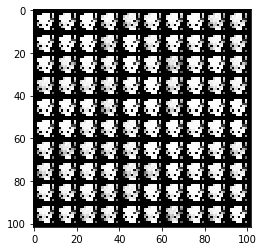

16it [00:01,  8.86it/s]


[11/200]: loss_d: 0.275, loss_g: 3.140


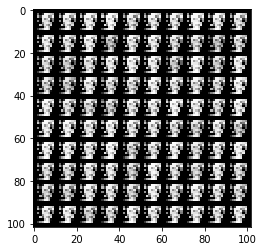

16it [00:01,  9.25it/s]


[12/200]: loss_d: 0.417, loss_g: 2.789


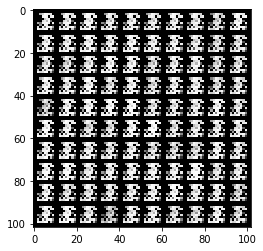

16it [00:02,  5.90it/s]


[13/200]: loss_d: 0.405, loss_g: 3.166


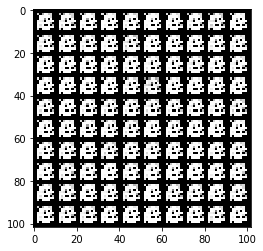

16it [00:03,  4.20it/s]


[14/200]: loss_d: 0.245, loss_g: 3.258


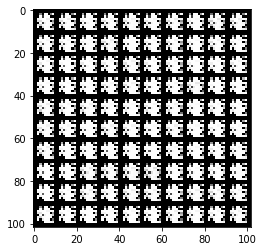

16it [00:04,  3.66it/s]


[15/200]: loss_d: 0.187, loss_g: 3.264


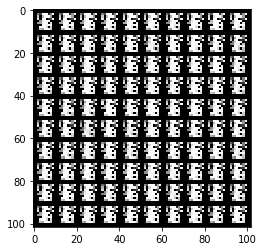

16it [00:04,  3.33it/s]


[16/200]: loss_d: 0.177, loss_g: 3.267


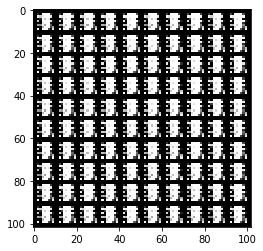

12it [05:52, 103.25s/it]

In [ ]:
n_epoch = 200
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, labels) in tqdm(enumerate(train_loader)):
        D_losses.append(D_train(D, x, labels, x_dim, z_dim))

        g_loss = G_train(G, x, labels, z_dim)
        G_losses.append(g_loss)
        while g_loss > 3:
            g_loss = G_train(G, x, labels, z_dim)
            G_losses.append(g_loss)

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
         (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    
    with torch.no_grad():
        z = Variable(torch.cat((torch.randn(batch_size, z_dim), labels.view(-1, 1).float()), dim=1))
        G_output = G(z)

        imshow(torchvision.utils.make_grid(G_output[:, :-1].view(G_output.size(0), 1, 8, 8), nrow=10))

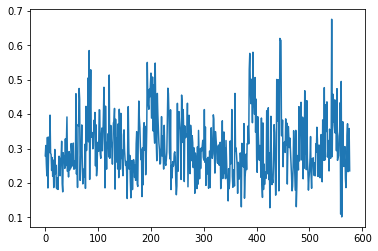

In [23]:
plt.plot(D_losses)

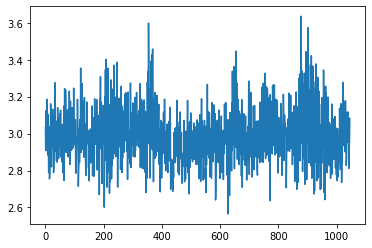

In [24]:
plt.plot(G_losses)

### DCGAN

In [3]:
class DGenerator(nn.Module):
    def __init__(self):
        super(DGenerator, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, (6,5))
        self.upconv1 = nn.ConvTranspose2d(64, 64, 5, stride=2)
        self.conv2 = nn.Conv2d(64, 32, 3)
        self.upconv2 = nn.ConvTranspose2d(32, 16, 4, stride=2)
        self.conv3 = nn.Conv2d(16, 8, 5)
        self.upconv3 = nn.ConvTranspose2d(8, 1, 5)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.upconv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.upconv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = torch.tanh(self.upconv3(x))
        return x
    
class DDiscriminator(nn.Module):
    def __init__(self):
        super(DDiscriminator, self).__init__()

        self.conv1 = nn.Conv2d(1, 128, 7, stride=2)
        self.conv2 = nn.Conv2d(128, 128, 5, stride=2)
        self.conv3 = nn.Conv2d(128, 1, 3, stride=2)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.conv2(x))
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.conv3(x))
        x = torch.sigmoid(x.view(x.size()[0], -1))
        return x

In [6]:
def D_train(x, labels):
    D.zero_grad()

    x_real, y_real = torch.cat((x, labels.view(-1, 1, 1, 1).repeat(1, 1, 1, 28).float()), 
                               dim=2), torch.ones(batch_size, 1)
    x_real, y_real = Variable(x_real), Variable(y_real)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    z = z = Variable(torch.cat((torch.randn(batch_size, 1, 10, 10), 
                            labels.view(-1, 1, 1, 1).repeat(1, 1, 1, 10).float()), 
                           dim=2))
    x_fake, y_fake = G(z), Variable(torch.zeros(batch_size, 1))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return D_loss.data.item()

In [11]:
def G_train(x, labels):
    G.zero_grad()

    z = Variable(torch.cat((torch.randn(batch_size, 1, 10, 10), 
                            labels.view(-1, 1, 1, 1).repeat(1, 1, 1, 10).float()), 
                           dim=2))
    y = Variable(torch.ones(batch_size, 1))

    G_output = G(z)
    D_input = torch.cat((G_output, labels.view(-1, 1, 1, 1).repeat(1, 1, 1, 28).float()), dim=2)
    D_output = D(D_input)
    G_loss = criterion(D_output, y)

    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [7]:
batch_size = 100

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
G = DGenerator()
D = DDiscriminator()

In [9]:
criterion = nn.BCELoss() 

lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [12]:
n_epoch = 200
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, labels) in tqdm(enumerate(train_loader)):
        D_losses.append(D_train(x, labels))

        g_loss = G_train(x, labels)
        G_losses.append(g_loss)
        while g_loss > 3:
            g_loss = G_train(x, labels)
            G_losses.append(g_loss)

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
         (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    
    with torch.no_grad():
        z = Variable(torch.cat((torch.randn(batch_size, z_dim), labels.view(-1, 1).float()), dim=1))
        G_output = G(z)

        imshow(torchvision.utils.make_grid(G_output[:, :-1].view(G_output.size(0), 1, 28, 28), nrow=10))

600it [08:29,  1.18it/s]

[1/200]: loss_d: 1.295, loss_g: 0.725


NameError: name 'z_dim' is not defined

In [14]:
labels

tensor([1, 9, 2, 1, 4, 8, 6, 7, 5, 3, 5, 2, 8, 6, 6, 3, 0, 4, 7, 5, 8, 5, 1, 6,
        9, 4, 6, 5, 0, 4, 4, 9, 3, 2, 0, 2, 2, 5, 9, 2, 5, 4, 8, 2, 1, 1, 5, 0,
        6, 3, 7, 8, 9, 3, 6, 6, 3, 3, 5, 3, 2, 0, 5, 9, 7, 1, 8, 3, 9, 1, 0, 5,
        5, 5, 2, 3, 1, 9, 5, 1, 0, 4, 8, 3, 8, 1, 5, 4, 7, 0, 0, 5, 4, 9, 5, 7,
        6, 2, 6, 3])

In [ ]:
with torch.no_grad():
    z = Variable(torch.cat((torch.randn(batch_size, 1, 10, 10), 
                            labels.view(-1, 1, 1, 1).repeat(1, 1, 1, 10).float()), 
                           dim=2)), labels.view(-1, 1).float()), dim=1))
    G_output = G(z)

    imshow(torchvision.utils.make_grid(G_output[:, :-1].view(G_output.size(0), 1, 28, 28), nrow=10))

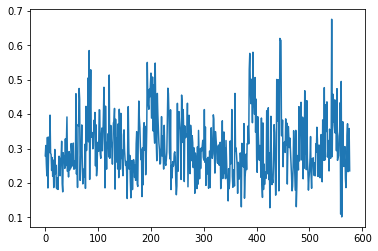

In [23]:
plt.plot(D_losses)

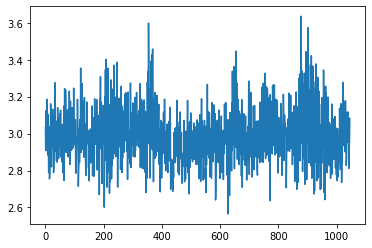

In [24]:
plt.plot(G_losses)